<a href="https://colab.research.google.com/github/PeterFrolkovic/Crank_Nicolson_Method_for_Advection/blob/main/ProjectOnCNMethodForAdvection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import zeros
from numpy import linspace
from scipy import sparse
from scipy.sparse.linalg import spsolve

# TASK 1 

 - dirichlet boundary conditions

In [2]:
def advection_solve_dirichlet(
    fi_0,
    v = lambda x: 1. + 0.*x,
    L=1.0, 
    T=0.5,
    I=10, 
    N=5,
    kappa=0.
  ):
  
  h = L / I
  tau = T / N
  
  x = linspace(0, L, I + 1)
  
  # Diagonals
  a = np.zeros(I + 1) # lower
  
  coef = ((tau * v(x)) / 2) * ((1 / (4 * h)))
  print('Maximal Courant number = ',8*np.max(coef))
  
  # Matrix
  # Formats: http://scipy-lectures.org/advanced/scipy_sparse/storage_schemes.html#sparse-matrix-classes
  A = sparse.spdiags([a, a, a, a], [-2, -1, 0, 1], I + 1, I + 1, format='lil')

  for i in range(2,I):
    A[i, i-2] = coef[i] * (1 - kappa)
    A[i, i-1] = coef[i] * ((1 - kappa) * (-4) + (1 + kappa) * -1)
    A[i, i]   = 1 + coef[i] * (1 - kappa) * 3
    A[i, i+1] = coef[i] * (1 + kappa)

  # Dirichlet boundary condition
  A[0, :] = 0
  A[0, 0] = 1 
 
  # special choices of kappa
  A[1, 0] = coef[1] * (1 + 1) * -1 # a
  A[1, 1] = 1                      # b
  A[1, 2] = coef[1] * (1 + 1)      # c
  
  A[-1, -3] = coef[-1] * (1 - -1)          # z
  A[-1, -2] = coef[-1] * (1 - -1) * (-4)    # a
  A[-1, -1] = 1 + coef[-1] * (1 - -1) * 3  # b

  A = sparse.csc_matrix(A) # To be more efficient and remove SparseEfficiencyWarning
  # print(A.todense())

  d = np.zeros(I + 1)   # prava strana
  
  fi = np.zeros([N + 1, I + 1])
  fi[0] = fi_0(x,0.)

  def calc_d(fi_n, i, k): 
    # if else here is a hack, because python is throwing index out of bounds
    left = 0 if k == 1 else ((1 - k) * (3*fi_n[i] - 4*fi_n[i - 1] + fi_n[i - 2]))
    right = 0 if k == -1 else (1 + k) * (fi_n[i + 1] - fi_n[i - 1])
    return fi_n[i] - coef[i] * (left + right)
    # Previous solution:
    # return fi_n[i] - coef[i] * ( (1 - k) * (3*fi_n[i] - 4*fi_n[i - 1] + fi_n[i - 2]) + (1 + k) * (fi_n[i + 1] - fi_n[i - 1]) )
  

  for n in range(N):
    d[0] = fi_0(0.,(n+1)*tau)
    d[1] = calc_d(fi[n], 1, k=1)
    d[-1] = calc_d(fi[n], len(d) - 1, k=-1)
    for i in range(2, I):
      d[i] = calc_d(fi[n], i, kappa)
  
    fi[n + 1] = spsolve(A, d)
  
  return fi, x

Maximal Courant number =  1.0


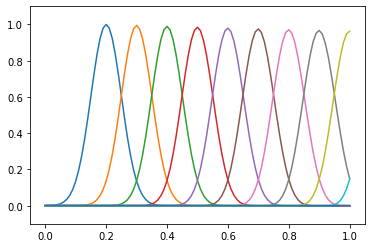

In [3]:
def plot_nth(solution, x, n):
  for i, _ in enumerate(solution):
    if i % n == 0:
      plt.ylim([-.1, 1.1])
      plt.plot(x, solution[i])
  plt.show()


gaus = lambda x,t: np.exp( -0.5 * ((x-0.2)**2) / .05**2 )
  
res, x = advection_solve_dirichlet(gaus,  L=1.0, T=1.,I=100, N=100, kappa=0)

plot_nth(res, x, 10)



Maximal Courant number =  1.0


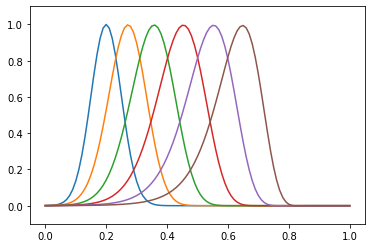

In [4]:
# With different speed
res, x = advection_solve_dirichlet(gaus, v = lambda x: 4*x*(1-x), L=1., T=.5, I=100, N=50, kappa=0)
plot_nth(res, x, 10)

# Task 2

periodic boundary conditions

In [5]:
def advection_solve(
    fi_0,
    v = lambda x: 1 + 0*x,
    L=1.0, T=0.5,
    I=100, N=50,
    kappa=0
  ):
  
  h = L / I
  tau = T / N
  
  x = linspace(0, L, I + 1)
  
  # Diagonals
  a = np.zeros(I + 1) # lower
  
  coef = ((tau * v(x)) / 2) * ((1 / (4 * h)))
  print('Maximal Courant number = ',8*np.max(coef))

  # Matrix
  # Formats: http://scipy-lectures.org/advanced/scipy_sparse/storage_schemes.html#sparse-matrix-classes
  A = sparse.spdiags([a, a, a, a], [-2, -1, 0, 1], I + 1, I + 1, format='lil')

  for i in range(2,I):
    A[i, i-2] = coef[i] * (1 - kappa)
    A[i, i-1] = coef[i] * ((1 - kappa) * (-4) + (1 + kappa) * -1)
    A[i, i]   = 1 + coef[i] * (1 - kappa) * 3
    A[i, i+1] = coef[i] * (1 + kappa)

# Initial periodic condition
  A[0, 0] = 1   
  A[0, -1] = -1
  
  # periodic solution
  i=1
  A[i, I-1] = coef[i] * (1 - kappa)
  A[i, i-1] = coef[i] * ((1 - kappa) * (-4) + (1 + kappa) * -1)
  A[i, i]   = 1 + coef[i] * (1 - kappa) * 3
  A[i, i+1] = coef[i] * (1 + kappa)
 
  i=I
  A[i, i-2] = coef[i] * (1 - kappa)
  A[i, i-1] = coef[i] * ((1 - kappa) * (-4) + (1 + kappa) * -1)
  A[i, i]   = 1 + coef[i] * (1 - kappa) * 3
  A[i, 1] = coef[i] * (1 + kappa)

  A = sparse.csc_matrix(A) # To be more efficient and remove SparseEfficiencyWarning
  # print(A.todense())

  d = np.zeros(I + 1)   # rhs
  
  fi = np.zeros([N + 1, I + 1])
  fi[0] = fi_0(x,0.)
  

  def calc_d(fi_n, i, k): 
    left =  (1 - k) * (3*fi_n[i] - 4*fi_n[i - 1] + fi_n[i - 2]) if i>1 else ((1 - k) * (3*fi_n[i] - 4*fi_n[i - 1] + fi_n[-2]))
    right = (1 + k) * (fi_n[i + 1] - fi_n[i - 1]) if i<I else (1 + k) * (fi_n[1] - fi_n[i - 1])
    return fi_n[i] - coef[i] * (left + right)
    # Previous solution:
    # return fi_n[i] - coef[i] * ( (1 - k) * (3*fi_n[i] - 4*fi_n[i - 1] + fi_n[i - 2]) + (1 + k) * (fi_n[i + 1] - fi_n[i - 1]) )
  

  for n in range(N):
    d[0] = 0
    for i in range(1, I+1):
      d[i] = calc_d(fi[n], i, kappa)
  
    fi[n + 1] = spsolve(A, d)
  
  return fi, x


Maximal Courant number =  1.0


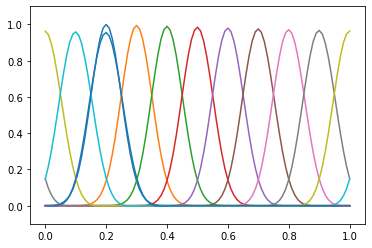

In [6]:
def plot_nth(solution, x, n):
  for i, _ in enumerate(solution):
    if i % n == 0:
      plt.ylim([-.1, 1.1])
      plt.plot(x, solution[i])
  plt.show()

gaus = lambda x,t: np.exp( -0.5 * ((x-0.2-t)**2) / .05**2 )

res, x = advection_solve(gaus, L=1.0, T=1.,I=100, N=100, kappa=0)

plot_nth(res, x, 10)


Maximal Courant number =  0.8660254037844386


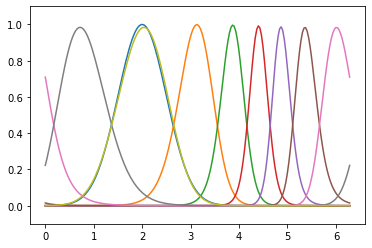

In [7]:
# With different speed
gaus = lambda x,t: np.exp( -0.5 * ((x-2)**2) / .5**2 )

res, x = advection_solve(gaus, v = lambda x: 2 + np.sin(x),  L=2.*np.pi, T=2.*np.pi / np.sqrt(3.), I=200, N=400, kappa=0)
# the exact solution is periodic 
plot_nth(res, x, 50)

# Error measurement

numerical error should be one quarter smaller when the steps τ and h are halved

## Testing accuracy with the known exact function

In [8]:
def create_f(x, t, a, b, c, d, v): 
  return a+b*(x - v*t) +c*(x - v*t)**2+d*(x- v*t)**3

def solve_exact(
    f,
    v = lambda x: 1 + 0*x,
    L=1.0, 
    T=0.5,
    I=100, 
    N=50,
  ):

  x = linspace(0, L, I + 1)
  t = linspace(0, T, N + 1)

  fi = np.zeros([N + 1, I + 1])
  for n in range(0, N+1):
    for i in range(0, I+1):
      fi[n][i] = f(x[i],t[n]) 

  return fi, x

def calculate_err(f, num_res, exact_res, L=1, T=1, I=1, N=1, log=False):
  """ Returns Tuple[Error, Error_T] """

  h = L / I
  tau = T / N

  if log:
    print('h =', h)
    print('tau =', tau)

  err = h * tau * np.sum(np.abs(exact_res - num_res))
  err_T = h * np.sum(np.abs(exact_res[-1] - num_res[-1]))

  return err, err_T


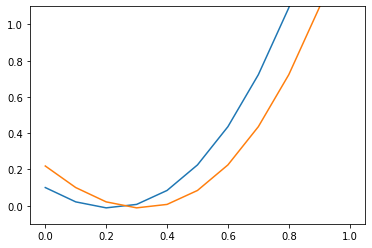

Maximal Courant number =  1.0


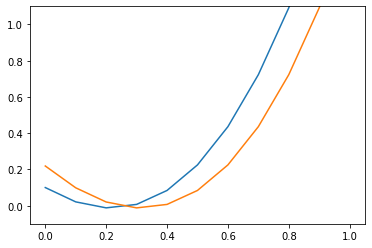

Maximal Courant number =  0.5
h = 0.1
tau = 0.05
Maximal Courant number =  0.5
h = 0.05
tau = 0.025


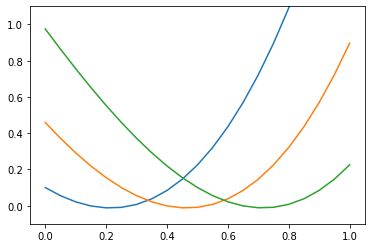

Global errors: = 0.00010393446395259307 0.0005475441028196026
Last errors: = 0.00031273161709237976 0.0016971812580575162
Ratio of global errors: = 5.268166900532149
Ratio of global errors: = 5.42695770206111


In [9]:
L = 1.
T = .1
I=10
N=1

# choose your constants
f = lambda x,t: create_f(x,t,a=0.1,b=-1,c=2,d=1,v=1)
exact_res, x = solve_exact(f, L=L, T=T, I=I, N=N)
plot_nth(exact_res, x, 1)

num_res, x = advection_solve_dirichlet(f, L=L, T=T, I=I, N=N, kappa=0)
plot_nth(num_res, x, 1)

# Grid 1 
L=1.
T=.5
I=10
N=10

exact_res, x = solve_exact(f, L=L, T=T, I=I, N=N)
num_res, x = advection_solve_dirichlet(f, L=L, T=T, I=I, N=N, kappa=0)
err_1, err_T_1 = calculate_err(
    f, num_res, exact_res,
    L=L, T=T, I=I, N=N,  log=True
    )

# Grid 2
I *= 2
N *= 2
exact_res, x = solve_exact(f, L=L, T=T, I=I, N=N)
num_res, x = advection_solve_dirichlet(f, L=L, T=T, I=I, N=N, kappa=0)
err_2, err_T_2 = calculate_err(
    f, num_res, exact_res,
    L=L, T=T, I=I, N=N, log=True
    )

plot_nth(num_res, x, 10)
print('Global errors: =', err_2 , err_1)
print('Last errors: =', err_T_2 , err_T_1)
if (err_2>1.0e-12): print('Ratio of global errors: =', err_1/err_2)
if (err_T_2>1.0e-12): print('Ratio of global errors: =', err_T_1/err_T_2)

Maximal Courant number =  1.0
Maximal Courant number =  1.0
Maximal Courant number =  1.0
Maximal Courant number =  1.0
Maximal Courant number =  1.0
Maximal Courant number =  1.0
Maximal Courant number =  1.0


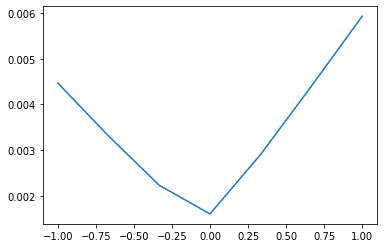

In [10]:
a=1
b=1
c=1
d=1
v=1


L=1.0 
T=0.5
I=10 
N=5


n_k = 7
kappas = np.linspace(-1,1,n_k)
# kappas = [-1,0, 1./3,1]

errs_N = []
errs_T = []

for i,kappa in enumerate(kappas):
  # if i/n_k % .05 == 0:
  #  print(i*100/n_k,"%")

  # c != 0 && d == 0
  f = lambda x,t: create_f(x,t,a=0,b=0,c=0,d=1,v=1)

  exact_res, x = solve_exact(f, L=L, T=T, I=I, N=N)  
  num_res, x = advection_solve_dirichlet(f, L=L, T=T, I=I, N=N, kappa=kappa)
  err, err_T = calculate_err(
    f, num_res, exact_res,
    L=L, T=T, I=I, N=N
    )
  errs_N.append(err)
  errs_T.append(err_T)

plt.plot(kappas,errs_T)
plt.show()



## Checking error when unknown exact solution

Testing this with the periodic boundary conditions.

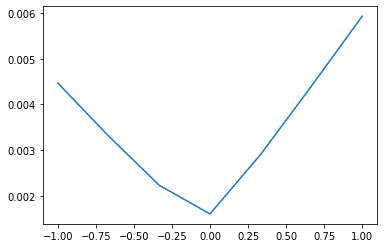

In [11]:
plt.plot(kappas,errs_T)
plt.show()

In [12]:
L = 1.0
T = 0.5
I=200
N=100

res_1, x = advection_solve(gaus, L=L, T=T,I=I, N=N, kappa=-1)
res_2, x = advection_solve(gaus, L=L, T=T,I=2*I, N=2*N, kappa=-1)

h = L / I
tau = T / N

print('Error =', h * tau * np.sum(np.abs(res_1 - res_2[::2, ::2])))

Maximal Courant number =  1.0
Maximal Courant number =  1.0
Error = 0.0005966648581554996


Different kappas

Maximal Courant number =  1.0
Maximal Courant number =  1.0
Maximal Courant number =  1.0
Maximal Courant number =  1.0
Maximal Courant number =  1.0
Maximal Courant number =  1.0
Maximal Courant number =  1.0
Maximal Courant number =  1.0
Maximal Courant number =  1.0
Maximal Courant number =  1.0
Maximal Courant number =  1.0
Maximal Courant number =  1.0
Maximal Courant number =  1.0
Maximal Courant number =  1.0


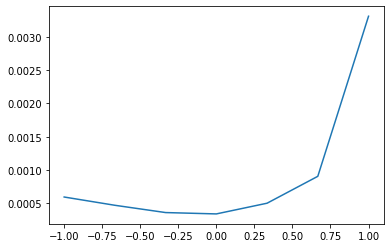

In [13]:
kappas = np.linspace(-1,1,7)
errors = []

for k in kappas:
  res_1, x = advection_solve(gaus, L=L, T=T,I=I, N=N, kappa=k)
  res_2, x = advection_solve(gaus, L=L, T=T,I=2*I, N=2*N, kappa=k)

  error = h * tau * np.sum(np.abs(res_1 - res_2[::2, ::2]))
  errors.append(error)

plt.plot(kappas,errors)
plt.show()
